<a href="https://colab.research.google.com/github/SoniaPMi/Master-IA/blob/main/Time_series_prediction_LSTM_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Airline passengers prediction using LSTM in Keras

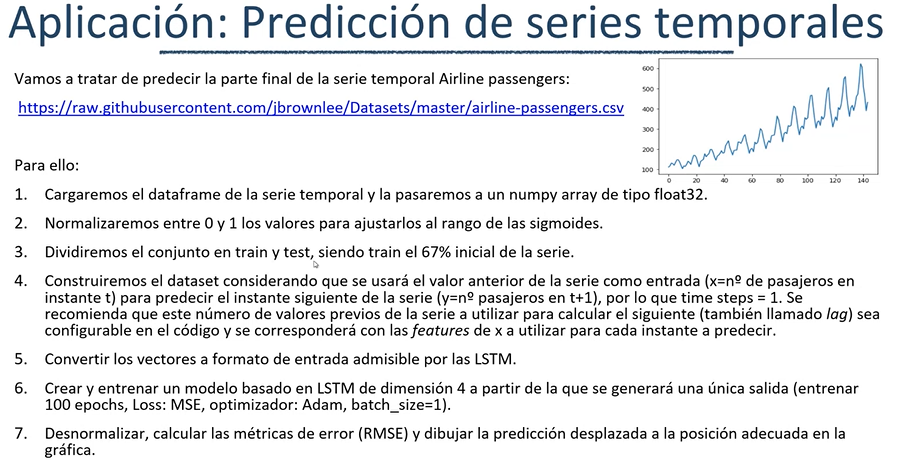

In [2]:
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [4]:
# load the dataset
#dataframe = pandas.read_csv("/content/airline-passengers.csv", separed=",")
dataframe = pandas.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv', usecols=[1], engine='python')

dataset = dataframe.values
dataset = dataset.astype('float32')
dataset.shape

(144, 1)

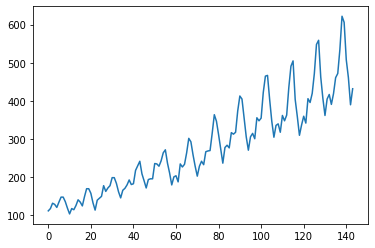

In [5]:
plt.plot(dataset)
plt.show()

In [8]:
# normalize the dataset between [0,1]
scaler = MinMaxScaler(feature_range=(0, 1)) #pongo rango
dataset = scaler.fit_transform(dataset) #aplico el rango al dataset

In [10]:
# Function to convert an array of values into a dataset matrix.
# By default create_dataset will create a dataset where X is the number of passengers at a given time (t) and Y is the number of passengers at the next time (t + 1).
# So the time step is 1 by default, and at a fixed time step we will use "lag" features

#lag = 1 intante temporal pasado para predecir un instante temporal futuro

def create_dataset(dataset, lag=1):  # lag is the number of previous values to consider for predicting next one
	dataX, dataY = [], []
	for i in range(len(dataset)-lag):
		a = dataset[i:(i+lag), 0] # slice of "lag" length starting at i
		dataX.append(a)
		dataY.append(dataset[i + lag, 0]) # target = next time step
	return numpy.array(dataX), numpy.array(dataY)

In [11]:
# First way for building the dataset: First split in train/test, then apply lags to create the matrices

# split into train and test sets
#train_size = int(len(dataset) * 0.67)
#test_size = len(dataset) - train_size
#train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
#print(len(train), len(test))

# build matrices
#lag = 1
#trainX, trainY = create_dataset(train, lag)
#testX, testY = create_dataset(test, lag)
#print(trainX.shape)
#print(testX.shape)
#print(trainX[0:5])
#print(trainY[0:5])

In [12]:
# Another way for building the dataset: First build the lag matrix, then split in train/test
# In this way we keep continuity between the sets and do not waste samples.
lag=1
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size

dataX, dataY = create_dataset(dataset, lag)
trainX, trainY = dataX[0:train_size,:], dataY[0:train_size]
testX, testY = dataX[train_size:len(dataset),:], dataY[train_size:len(dataset)]

print(trainX.shape)
print(testX.shape)
print(trainX[0:5])
print(trainY[0:5])

(96, 1)
(47, 1)
[[0.01544401]
 [0.02702703]
 [0.05405405]
 [0.04826255]
 [0.03281853]]
[0.02702703 0.05405405 0.04826255 0.03281853 0.05984557]


In [13]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [14]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, lag)))  # input_shape=[time steps, features]
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
96/96 [==============================] - 2s 2ms/step - loss: 0.0546
Epoch 2/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0270
Epoch 3/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0196
Epoch 4/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0176
Epoch 5/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0166
Epoch 6/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 7/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0147
Epoch 8/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0139
Epoch 9/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0129
Epoch 10/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0121
Epoch 11/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0111
Epoch 12/100
96/96 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/100
96/96 [=================

In [15]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert scaling
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 23.71 RMSE
Test Score: 46.36 RMSE


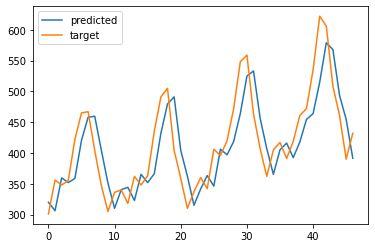

In [16]:
plt.plot(testPredict, label='predicted')
plt.plot(testY[0], label='target')
plt.legend()
plt.show()

In [17]:
# Optional: plot train and test predictions in the same graph in different colors.
# We must shift train and test predictions to the correct position.
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=80)

trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[# completar, :] = trainPredict 
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[# completar, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

SyntaxError: ignored